In [2]:
!pip install munch
!pip install imageio

In [3]:
import jax.numpy as jnp
from jax import jacfwd, vmap, jit
from jax.scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt
import munch
import numpy as np

In [4]:
x_d1 = -2
x_d3 = 1

In [5]:
class ThreePopulationMFG(object):
    def __init__(self, T, Nt, xl, xr, N, nu, alphas, sigmas, lambdas, eps):
        self.T = T
        self.Nt = Nt
        self.xl = xl
        self.xr = xr
        self.N = N
        self.nu = nu
        self.alphas = alphas
        self.sigmas = sigmas
        self.lambdas = lambdas
        self.dt = T / Nt
        self.dx = (xr - xl) / N
        self.x_grid = jnp.linspace(xl, xr, N)
        self.t_grid = jnp.linspace(0, T, Nt)
        self.eps = eps
        self.h = (xr - xl) / N


    def mu0(self, x, population_index):
        if population_index == 0:
            midpoint = (self.xr + self.xl) / 2
            sigma_mu = 1  # Define your standard deviation
            a, b = (self.xl - midpoint) / sigma_mu, (self.xr - midpoint) / sigma_mu
            return norm.pdf(x, loc=midpoint, scale=sigma_mu)
        elif population_index == 1:
            width = self.xr - self.xl  # The width of the distribution
            uniform_distribution = jnp.ones(self.N) / width  # Uniform distribution over the interval [xl, xr
            return uniform_distribution
        elif population_index == 2:
            midpoint = (self.xr + self.xl) / 2
            sigma_mu = 1.5  # Define your standard deviation
            a, b = (self.xl - midpoint) / sigma_mu, (self.xr - midpoint) / sigma_mu
            return norm.pdf(x, loc=midpoint, scale=sigma_mu)

    def uT(self, x, population_index):
        if population_index == 0:
            return (x - x_d1) ** 2  # For population 1
        elif population_index == 1:
            return 0
        elif population_index == 2:
            return (x - x_d3) ** 2


    def local_kernel(self, x, y):
        # Calculate the Euclidean distance between two points
        distance = jnp.linalg.norm(x - y)
        # Return 1 if the distance is less than or equal to epsilon, else return 0
        return jnp.where(distance <= self.eps, 1, 0)

    def psi(self, Xtk, y, lambda_r, K_d):
        numerator = self.local_kernel(Xtk, y)

        denominator_terms = []

        integral_approx = jnp.sum(self.local_kernel(Xtk, y)) /self.N
        denominator_terms.append(jnp.maximum(lambda_r * integral_approx * K_d,  0.05))
        denominator = jnp.sum(jnp.array(denominator_terms))

        return numerator / denominator

    def prolong(self, Uvec, Mvec, idx):
        Umtx = jnp.reshape(Uvec, (self.Nt, self.N))
        Mmtx = jnp.reshape(Mvec, (self.Nt, self.N))

        U = jnp.zeros((self.Nt + 1, self.N))
        M = jnp.zeros((self.Nt + 1, self.N))

        U = U.at[:self.Nt, :].set(Umtx)
        M = M.at[1:, :].set(Mmtx)

        M0 = self.mu0(self.x_grid, idx)  # Assuming mu0 returns an array of shape (N,)
        UT = vmap(self.uT, in_axes=(0, None))(self.x_grid, idx)
        U = U.at[self.Nt, :].set(UT)
        M = M.at[0, :].set(M0)
        return U, M

    def K_d(self, x, y, sigma):
        mu_k_t_cumsum = jnp.cumsum(x)
        mu_r_t_cumsum = jnp.cumsum(y)

        w_p = jnp.sum(jnp.abs(mu_k_t_cumsum - mu_r_t_cumsum))

        return jnp.where(w_p <= sigma, jnp.exp(-w_p), 0.0)


    def G_m(self, x, mu, population_index):
        """
        Calculate the G_M function for a given population.

        Parameters:
        x (array): Spatial grid points.
        mu (list of arrays): Distributions of each population.
        population_index (int): Index of the population.

        Returns:
        array: Computed G_M values for each point in x.
        """

        alpha_k = self.alphas[population_index]
        sigma_k = self.sigmas[population_index]
        # Calculate the interaction term
        interaction_term = jnp.zeros_like(x)
        for r, lambda_r in enumerate(self.lambdas):
            mu_r = mu[r]
            K_d_value = self.K_d(mu[population_index], mu_r, sigma_k)
            if (population_index == 0 and r == 2) or (population_index == 2 and r == 0):
                K_d_value = 0
            psi_values = vmap(lambda y: self.psi(x, y, lambda_r, K_d_value) * y)(self.x_grid)

            integral_approximation = jnp.sum(psi_values) / self.N
            interaction_term += lambda_r * integral_approximation * K_d_value

        # Calculate G_M
        G_M_value = -alpha_k * x + (1 - alpha_k) * interaction_term

        return G_M_value

    def g(self, x, q1, q2, m, idx):
        p1 = jnp.minimum(q1, 0)
        p2 = jnp.maximum(q2, 0)
        g_m = self.G_m(x, m, idx)

        b1 = jnp.minimum(g_m, 0)
        b2 = jnp.maximum(g_m, 0)

        return (p1 ** 2) / 2 + (p2 ** 2) / 2 + b1 * q1 + b2 * q2

    def hamilton(self, U, M, idx):
        dUR = (jnp.roll(U, -1) - U)/self.h
        dUL = (U - jnp.roll(U, 1))/self.h

        Hamiltonian = vmap(lambda x, q1, q2: self.g(x, q1, q2, M, idx))(self.x_grid, dUR, dUL)

        return Hamiltonian

    def hjb(self, ts, Uk1, Uk, Mk1, idx):
        UR = jnp.roll(Uk, -1)
        UL = jnp.roll(Uk, 1)

        Delta_U = - (2 * Uk - UR - UL) / self.h ** 2

        Dt_U = (Uk1 - Uk) / self.dt

        Hamiltonian = self.hamilton(Uk, Mk1, idx)

        return -Dt_U - self.nu * Delta_U + Hamiltonian - Mk1

    def fp_linearized_part(self, U, M, idx):
        UR = (jnp.roll(U, -1) - U) / self.h
        UL = (U - jnp.roll(U, 1)) / self.h

        URF = UR.flatten()
        ULF = UL.flatten()

        dGq1 = lambda x1, q1, q2: jnp.minimum(q1, 0)
        dGq2 = lambda x1, q1, q2: jnp.maximum(q2, 0)

        dGq1s = vmap(dGq1)(self.x_grid, URF, ULF)
        dGq2s = vmap(dGq2)(self.x_grid, URF, ULF)

        dGq1s = jnp.multiply(dGq1s, M)
        dGq2s = jnp.multiply(dGq2s, M)

        dGqDifference1 = dGq1s - dGq2s

        dGqs2R = jnp.roll(dGq2s, -1)
        dGqs1L = jnp.roll(dGq1s, 1)

        A = - (dGqDifference1 + dGqs2R - dGqs1L) / self.h

        b = vmap(lambda x: self.G_m(x, M, idx))(self.x_grid)
        bp1 = lambda x: jnp.minimum(x, 0)
        bp2 = lambda x: jnp.maximum(x, 0)

        bp1s = vmap(bp1)(b)
        bp2s = vmap(bp2)(b)

        bp1s = jnp.multiply(bp1s, M)
        bp2s = jnp.multiply(bp2s, M)

        bpDifference1 = bp1s - bp2s

        bp2sR = jnp.roll(bp2s, -1)
        bp1sL = jnp.roll(bp1s, 1)

        B = - (bpDifference1 + bp2sR - bp1sL) / self.h

        MEQByHands = A + B

        return MEQByHands


    def solve_hjb(self, U0, M, lr, idx, tol=10**(-6), epoch=100):
        error = 1
        iter_num = 0

        U = U0
        while error > tol and iter_num < epoch:
            b = self.hjb_sys_vec(U, M, idx)
            jacobi = jacfwd(self.hjb_sys_vec)(U, M, idx)
            dz = jnp.linalg.solve(jacobi, b.flatten())
            U = U - lr * dz

            error = jnp.dot(dz, dz)
            print("             the error of solving hjb is {}".format(error))

            iter_num = iter_num + 1

        return U

    def fp(self, Uk, Mk1, Mk, idx):
        Dt_M = (Mk1 - Mk) / self.dt

        Mk1R = jnp.roll(Mk1, -1)
        Mk1L = jnp.roll(Mk1, 1)

        Delta_M = - (2 * Mk1 - Mk1R - Mk1L) / self.h**2

        adj = self.fp_linearized_part(Uk, Mk1, idx)

        return Dt_M - self.nu * Delta_M + adj

    def solve_fp(self, M0, U1, U2):
        jacobi = jacfwd(self.fp_sys_vec)(M0, U1, U2)
        b = self.fp_sys_vec(jnp.zeros(len(jacobi)), U1, U2)
        M = jnp.linalg.lstsq(jacobi, -b)
        return M[0]

    def hjb_sys(self, U, M, idx):
        ts = jnp.linspace(0, self.T, self.Nt + 1)
        hjbs = vmap(self.hjb, in_axes=(0, 0, 0, 0, None))(ts[:-1], U[1:, :], U[:-1, :], M[1:, :], idx)
        return hjbs

    def fp_sys(self, U, M, idx):
        fps = vmap(self.fp, in_axes=(0, 0, 0, None))(U[:-1, :], M[1:, :], M[:-1, :], idx)

        return fps


    def hjb_sys_vec(self, Uvec, Mvec, idx):
        U, M = self.prolong(Uvec, Mvec, idx)
        return self.hjb_sys(U, M, idx).flatten()

    def fp_sys_vec(self, Mvec, Uvec, idx):
        U, M = self.prolong(Uvec, Mvec, idx)

        return self.fp_sys(U, M, idx).flatten()


    def solve(self, tol=10**(-6), epoch=100, hjb_lr=1, hjb_epoch=100):
        U1 = jnp.zeros((self.Nt, self.N)).flatten()
        U2 = jnp.zeros((self.Nt, self.N)).flatten()
        U3 = jnp.zeros((self.Nt, self.N)).flatten()

        M1 = jnp.zeros((self.Nt, self.N)).flatten()
        M2 = jnp.zeros((self.Nt, self.N)).flatten()
        M3 = jnp.zeros((self.Nt, self.N)).flatten()

        error = 1
        iter_num = 0

        while error > tol and iter_num < epoch:
            new_U1 = self.solve_hjb(U1, M1, hjb_lr, epoch=hjb_epoch, idx=0)
            new_U2 = self.solve_hjb(U2, M2, hjb_lr, epoch=hjb_epoch, idx=1)
            new_U3 = self.solve_hjb(U3, M3, hjb_lr, epoch=hjb_epoch, idx=2)

            new_M1 = self.solve_fp(M1, new_U1, 0)
            new_M2 = self.solve_fp(M2, new_U2, 1)
            new_M3 = self.solve_fp(M3, new_U3, 2)

            U_err = jnp.dot(new_U1 - U1, new_U1 - U1) + jnp.dot(new_U2 - U2, new_U2 - U2) + jnp.dot(new_U3 - U3, new_U3 - U3)
            M_err = jnp.dot(new_M1 - M1, new_M1 - M1) + jnp.dot(new_M2 - M2, new_M2 - M2) + jnp.dot(new_M3 - M3, new_M3 - M3)
            error = U_err + M_err

            print('MFG error: {}'.format(error))

            U1, U2, U3, M1, M2, M3 = new_U1, new_U2, new_U3, new_M1, new_M2, new_M3
            iter_num += 1

        U1, M1 = self.prolong(U1, M1, 0)
        U2, M2 = self.prolong(U2, M2, 1)
        U3, M3 = self.prolong(U3, M3, 2)

        return U1, M1, U2, M2, U3, M3


In [6]:
np.set_printoptions(precision=20)

cfg = munch.munchify({
    'T' : 1,
    'Nt': 50,
    'xl': -5,
    'xr': 5,
    'N' : 50,
    'nu': 1,
    'alphas': [0.6, 0.4, 0.4],
    'sigmas': [1, 2, 1],
    'lambdas': [0.6, 0.2, 0.2],
    'eps': 0.8,
    'hjb_epoch': 200,
    'hjb_lr': 1,
    'epoch': 150,
    'lr': 0.7,
    'tol' : 10 ** (-6),
})

In [7]:
solver = ThreePopulationMFG(T=cfg.T, Nt=cfg.Nt, xl=cfg.xl, xr=cfg.xr, N=cfg.N, nu=cfg.nu, alphas=cfg.alphas, sigmas=cfg.sigmas, lambdas=cfg.lambdas, eps=cfg.eps)

TT = jnp.linspace(0, cfg.T, cfg.Nt + 1)
XX = jnp.linspace(cfg.xl, cfg.xr, cfg.N, endpoint=False)
TT, XX = jnp.meshgrid(TT, XX)

# U, M = solver.solve_mfg(cfg.lr, cfg.tol, cfg.epoch)
U1, M1, U2, M2, U3, M3 = solver.solve(cfg.tol, cfg.epoch, cfg.hjb_lr, cfg.hjb_epoch)


             the error of solving hjb is 537848.5
             the error of solving hjb is 77701.203125
             the error of solving hjb is 8498.072265625
             the error of solving hjb is 1052.70263671875
             the error of solving hjb is 47.93745422363281
             the error of solving hjb is 0.4930294156074524
             the error of solving hjb is 8.208365034079179e-05
             the error of solving hjb is 1.1759729301452637e-10
             the error of solving hjb is 0.0
             the error of solving hjb is 286730.78125
             the error of solving hjb is 35758.453125
             the error of solving hjb is 1414.980712890625
             the error of solving hjb is 12.248083114624023
             the error of solving hjb is 0.005307942628860474
             the error of solving hjb is 1.1213233008788848e-08
MFG error: 260861.453125
             the error of solving hjb is 28.193098068237305
             the error of solving hjb is 0.0004494169

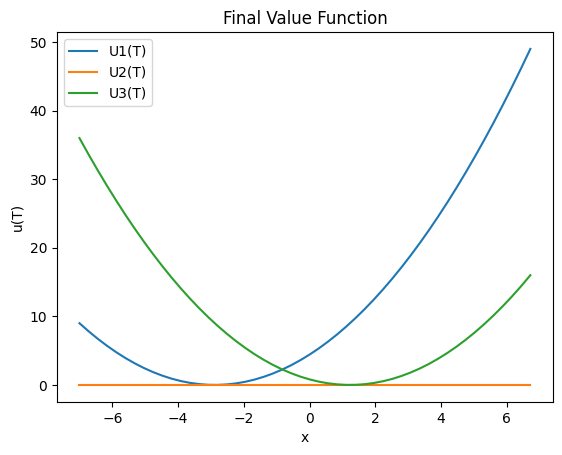

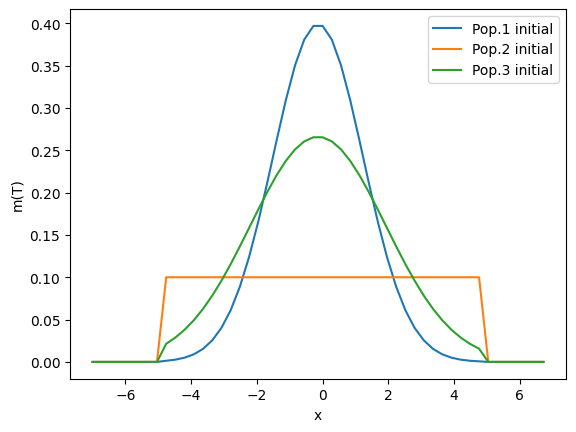

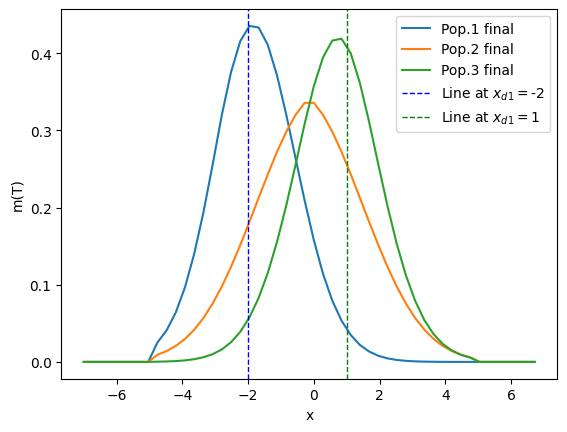

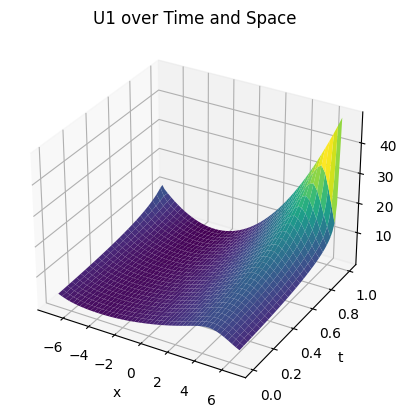

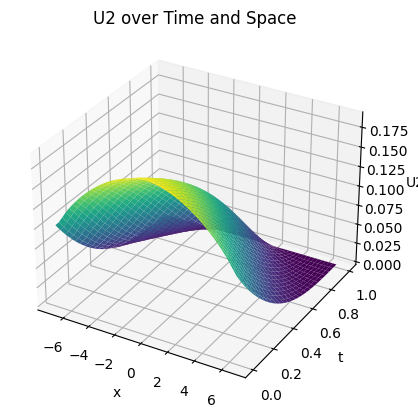

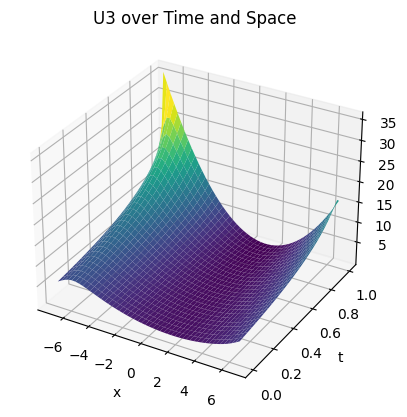

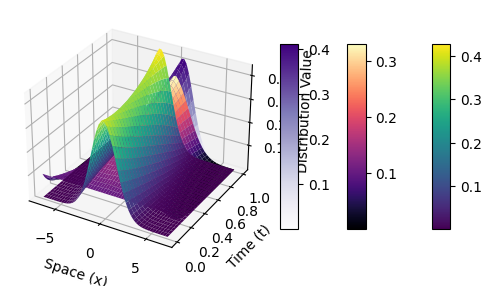

In [9]:
# Assuming cfg, U1, U2, M1, M2, x_d1, and x_d2 are already defined
TT = np.linspace(0, cfg.T, cfg.Nt + 1)
XX = np.linspace(-7, 7, cfg.N, endpoint=False)

# Final value function for both populations
plt.figure()
plt.plot(XX, U1[-1, :], label='U1(T)')
plt.plot(XX, U2[-1, :], label='U2(T)')
plt.plot(XX, U3[-1, :], label='U3(T)')
plt.title('Final Value Function')
plt.xlabel('x')
plt.ylabel('u(T)')
plt.legend()
plt.show()


M1_truncated= np.where((XX >= -5) & (XX <= 5), M1[0, :], 0)
M2_truncated = np.where((XX >= -5) & (XX <= 5), M2[0, :], 0)
M3_truncated= np.where((XX >= -5) & (XX <= 5), M3[0, :], 0)

# initial distribution for both populations
plt.figure()
plt.plot(XX,M1_truncated, label="Pop.1 initial")
plt.plot(XX, M2_truncated, label="Pop.2 initial")
plt.plot(XX, M3_truncated, label="Pop.3 initial")
# plt.axvline(x=x_d1, color='Blue', linestyle='--', linewidth=1, label=r'Line at $x_{d1}=$' + f'{x_d1}')
# plt.axvline(x=x_d3, color='Green', linestyle='--', linewidth=1, label=r'Line at $x_{d1}=$' + f'{x_d3}')
plt.xlabel('x')
plt.ylabel('m(T)')
plt.legend()
plt.savefig("initial.png", dpi=300)
plt.show()

M1_truncated_last = np.where((XX >= -5) & (XX <= 5), M1[-1, :], 0)
M2_truncated_last = np.where((XX >= -5) & (XX <= 5), M2[-1, :], 0)
M3_truncated_last = np.where((XX >= -5) & (XX <= 5), M3[-1, :], 0)
# Final distribution for both populations
plt.figure()
plt.plot(XX, M1_truncated_last, label="Pop.1 final")
plt.plot(XX, M2_truncated_last, label="Pop.2 final")
plt.plot(XX, M3_truncated_last, label="Pop.3 final")
plt.axvline(x=x_d1, color='Blue', linestyle='--', linewidth=1, label=r'Line at $x_{d1}=$' + f'{x_d1}')
plt.axvline(x=x_d3, color='Green', linestyle='--', linewidth=1, label=r'Line at $x_{d1}=$' + f'{x_d3}')
plt.xlabel('x')
plt.ylabel('m(T)')
plt.legend()
plt.savefig("final.png", dpi=300)
plt.show()

# 3D surface plot for value function U1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(XX, TT)
ax.plot_surface(X, Y, U1, cmap='viridis')
ax.set_title('U1 over Time and Space')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('U1')
plt.show()

# 3D surface plot for value function U2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U2, cmap='viridis')
ax.set_title('U2 over Time and Space')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('U2')
plt.show()

# 3D surface plot for value function U3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U3, cmap='viridis')
ax.set_title('U3 over Time and Space')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('U3')
plt.show()


# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the first surface M1 with a colormap
surf1 = ax.plot_surface(X, Y, M1, cmap='viridis', alpha=1)
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10)
# Plot the second surface M2 with a different colormap
surf2 = ax.plot_surface(X, Y, M2, cmap='magma', alpha=1)
fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=10)
surf3 = ax.plot_surface(X, Y, M3, cmap='Purples', alpha=1)
fig.colorbar(surf3, ax=ax, shrink=0.5, aspect=10)

# Setting the labels and title
ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Distribution Value')

# Display the plot
plt.show()

# Optionally save the figure
fig.savefig("M1_M2_surface_plots_with_cmap.png")

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

def plot_distribution_state(index):
    M1_truncated= np.where((XX >= -5) & (XX <= 5), M1[index, :], 0)
    M2_truncated = np.where((XX >= -5) & (XX <= 5), M2[index, :], 0)
    M3_truncated= np.where((XX >= -5) & (XX <= 5), M3[index, :], 0)
    plt.figure(figsize=(10, 6))
    plt.plot(XX, M1_truncated, color='blue')
    plt.plot(XX, M2_truncated, color='orange')
    plt.plot(XX, M3_truncated, color='green')
    # plt.axvline(x=x_d1, color='Blue', linestyle='--', linewidth=1, label=r'Line at $x_{d1}=$' + f'{x_d1}')  # LaTeX for subscript
    # plt.axvline(x=x_d3, color='Red', linestyle='--', linewidth=1, label=r'Line at $x_{d2}=$' + f'{x_d3}')
    plt.title(f'Distribution at State {index}')
    plt.xlabel('x')
    plt.ylabel('m(T)')
    # plt.ylim([0, M1.max()])  # Or set to a fixed range if preferred
    filename = f'temp_plot_{index}.png'
    plt.savefig(filename)
    plt.close()
    return filename

# Create a list to hold all filenames
filenames = []

# Loop over all states of M1 to create plots
for i in range(M1.shape[0]):
    filenames.append(plot_distribution_state(i))

# Create the animated gif
with imageio.get_writer('distribution_animation.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optionally, remove the temporary image files after creating the gif
for filename in filenames:
    os.remove(filename)

# Output the path to the gif
gif_path = 'distribution_animation.gif'
print(f"Your GIF is available at: {gif_path}")


<ipython-input-17-a70fb55d83da>:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Your GIF is available at: distribution_animation.gif
